In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from plotting_fxns import *

This notebook is intended to make plotting of the PyGEM-EB output straightforward for fast diagnostics after a model run. Most functions just need the information for the model run in the cell below. 

Specify the plotting style to use and the figure name to save the plot.

Run the following cells to plot the data. For information on any of the plotting functions, run 'help(name_of_function)'. Available functions are:
- simple_plot
- plot_AWS
- plot_stake_data
- compare_runs
- stacked_eb_barplot

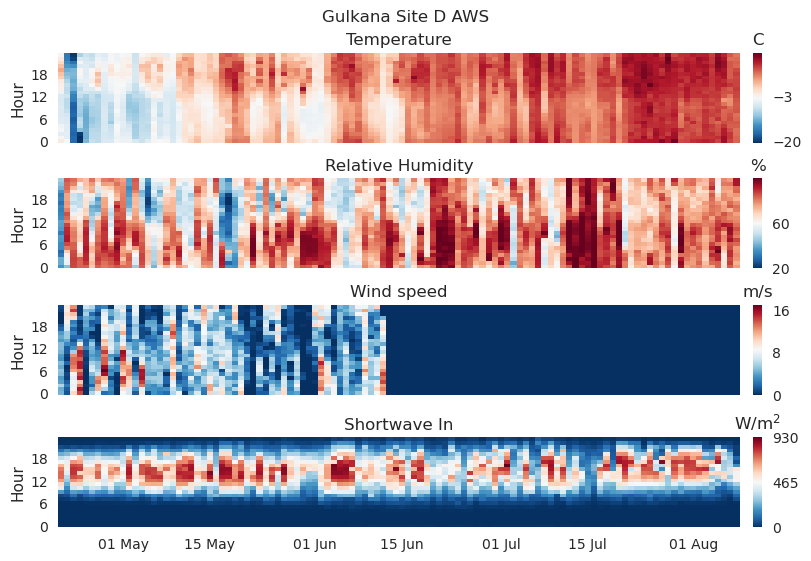

In [21]:
df = pd.read_csv('~/research/climate_data/AWS/Gulkana/gulkana-d-23.csv',index_col=0,skiprows=2)
df = df.set_index(pd.to_datetime(df['Datetime']))
df = df.resample('h').mean()
dates = ['2023-04-21 00:00:00','2023-08-08 23:00:00']
df2 = pd.read_csv('~/research/climate_data/AWS/Gulkana/4_17-8_10_2023.CSV',index_col=0)
df2 = df2.set_index(pd.to_datetime(df2.index))
df['wind'] = df['wind'].mask(df['wind'] < 0,0)
df['temp'] = (df['Temp']-32)*5/9
df['rh'] = df['RH']
df = df.loc[dates[0]:dates[1]]
df2 = df2.loc[dates[0]:dates[1]]
df['SWin'] = df2['sw_down_Avg'].mask(df2['sw_down_Avg']<0,0)/3600
plot_AWS(df,['temp','rh','wind','SWin'],dates,'Gulkana Site D, 2023')

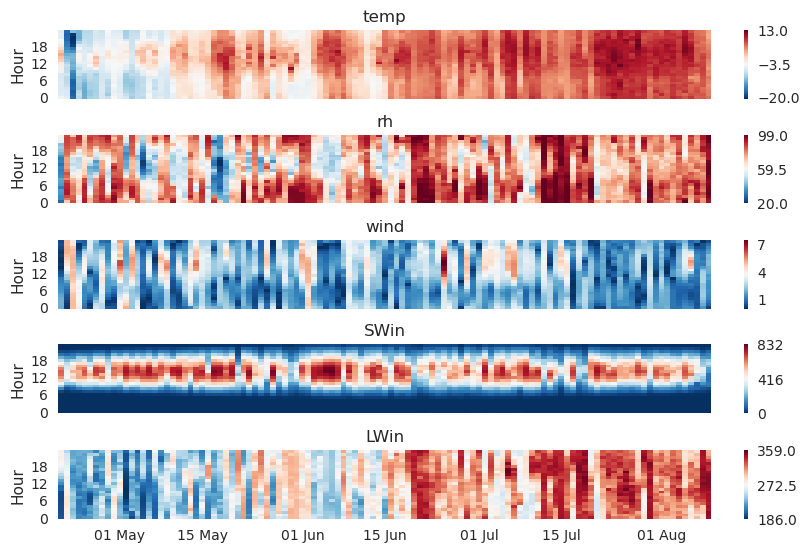

In [61]:
df = pd.read_csv('~/research/climate_data/AWS/Preprocessed/gulkanaD/gulkanaD_wERA5.csv',index_col=0)
df = df.set_index(pd.to_datetime(df.index))
dates = ['2023-04-21 00:00:00','2023-08-09 00:00:00']
plot_AWS(df,['temp','rh','wind','SWin','LWin'],dates)
# df['SWin'] = df['SWin'] / 3600
# df['LWin'] = df['LWin'] / 3600
# df.to_csv('~/research/climate_data/AWS/Preprocessed/gulkanaD/gulkanaD_wERA5.csv')

In [36]:
# Load in the data and get the dates available for the model run
# Gulkana_2023_09_27_GOOD.nc' 
output_fn = '/home/claire/research/Output/EB/Gulkana_2023_10_31_1.nc' 
ds,startdate,enddate = getds(output_fn)
# ds_CNR4,_,_ = getds('/home/claire/research/Output/EB/Gulkana_2023_09_27_GOOD.nc' )
bin = 0
stake_df = pd.read_csv('~/research/MB_data/Stakes/gulkanaAB23.csv')

88.94858680555556
36.21044394549666


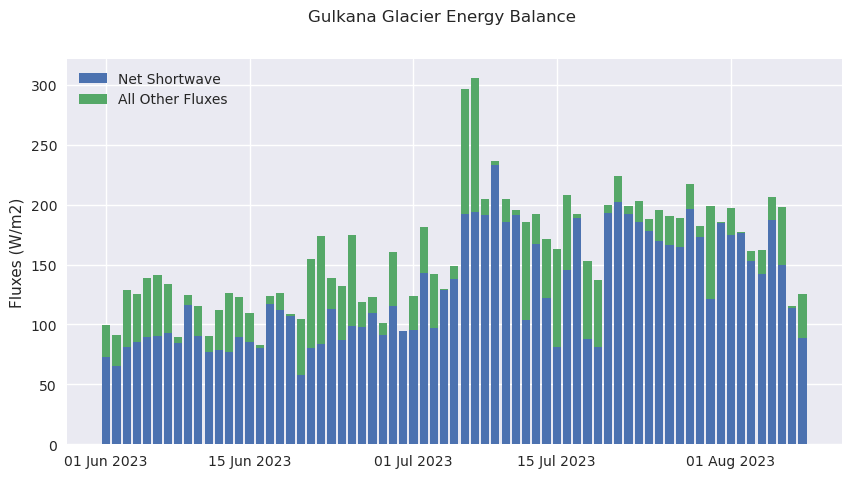

In [21]:
stacked_eb_barplot(ds,['06-01-2023 00:00:00','08-08-2023 23:00:00'],t='Gulkana Glacier Energy Balance',savefig='/home/claire/research/Output/gulkanaebbarplot.png')

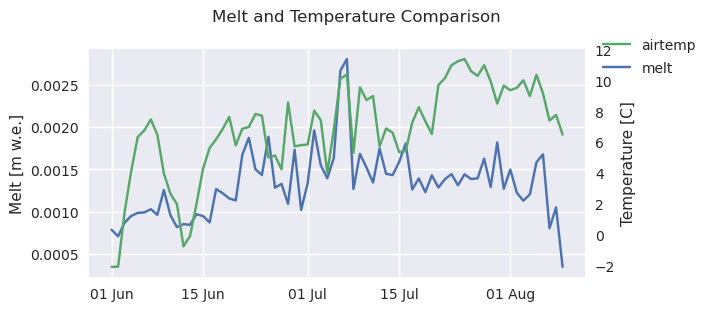

In [38]:
simple_plot(ds,0,[pd.to_datetime('06-01-2023 00:00:00'),enddate],[['melt','airtemp']],new_y='airtemp',skinny=False,res='d',t='Melt and Temperature Comparison')

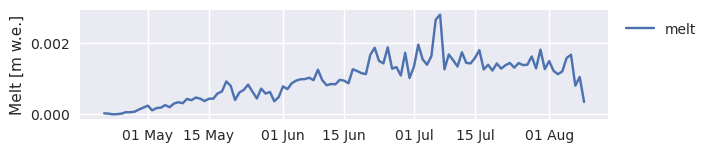

In [39]:
simple_plot(ds,0,[startdate,enddate],[['melt']])

KeyError: 'layergrainsize'

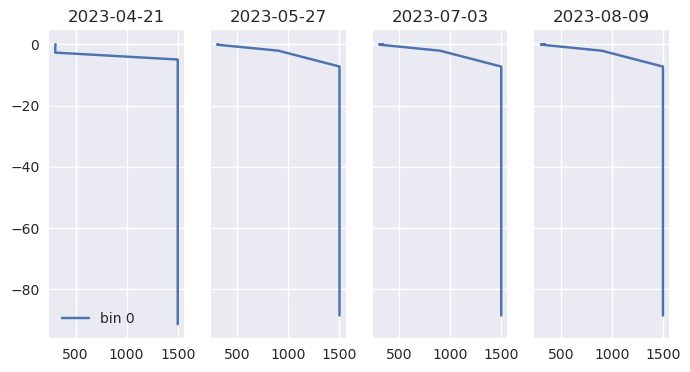

In [43]:
plot_layers(ds,'layergrainsize',pd.date_range(startdate,enddate,4))

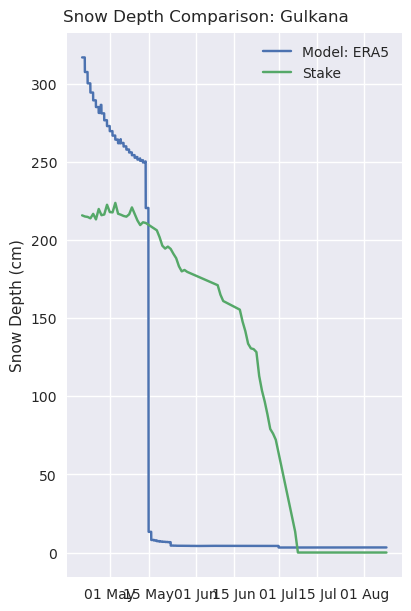

In [40]:
plot_snow_depth(stake_df,[ds],[startdate,enddate],['Model: ERA5'],0,t='Snow Depth Comparison: Gulkana')

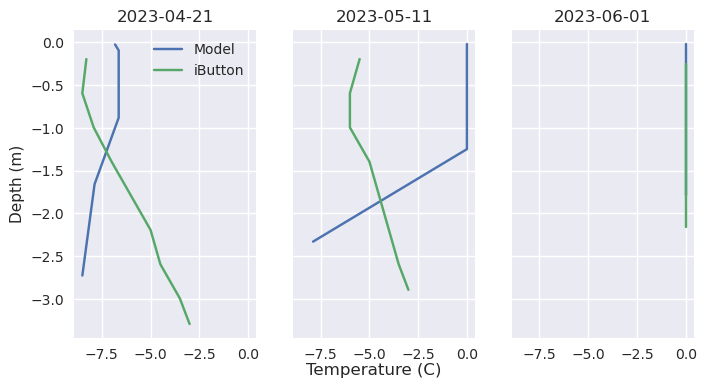

In [31]:
plot_iButtons(ds,0,pd.date_range('04-21-2023 00:00','06-01-2023 00:00',periods=3))

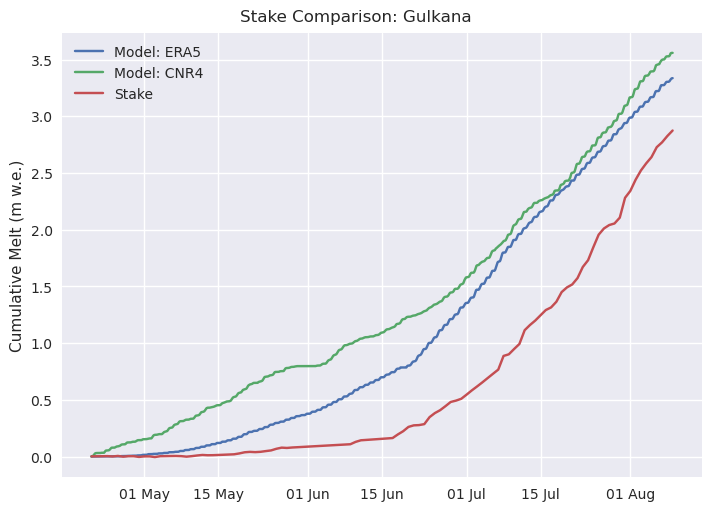

In [66]:
plot_stake_data(stake_df,[ds,ds_CNR4],[startdate,enddate],['Model: ERA5','Model: CNR4'],0,t='Stake Comparison: Gulkana')

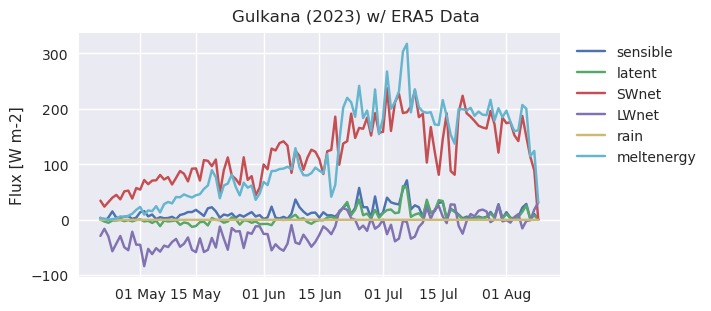

In [67]:
simple_plot(ds,0,[startdate,enddate],[['sensible','latent','SWnet','LWnet','rain','meltenergy']],skinny=False,res='d',t='Gulkana (2023) w/ ERA5 Data')

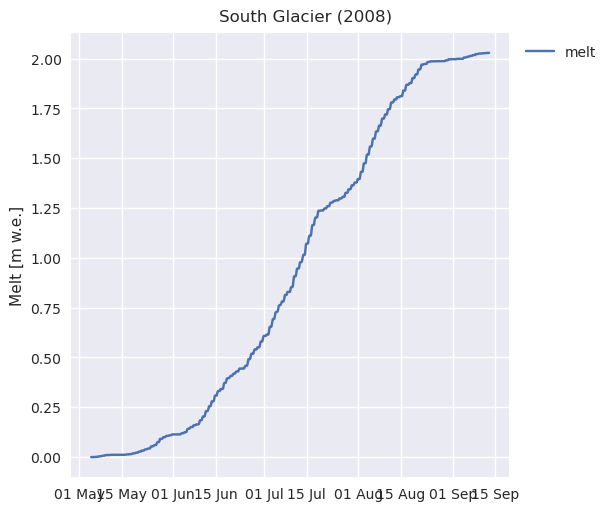

In [81]:
simple_plot(ds,bin,[startdate,enddate],[['melt']],t='South Glacier (2008)',skinny=False,res='h')

In [29]:
MB_vars = ['melt','runoff','accum','refreeze'] # ,'snowdepth'
EB_vars = ['surftemp','SWnet','LWnet','rain','sensible','latent','meltenergy']
temp_vars = ['airtemp','surftemp']

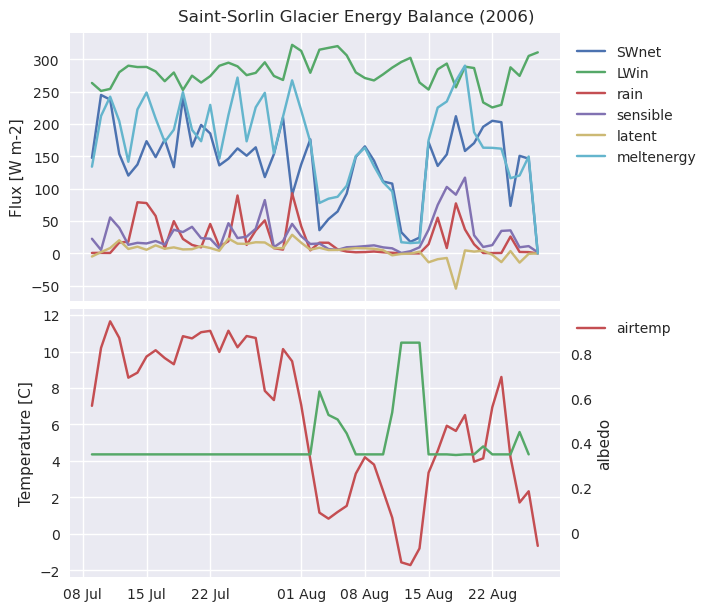

In [30]:
simple_plot(ds,bin,['2006-07-09','2006-08-27'],[['SWnet','LWin','rain','sensible','latent','meltenergy'],['albedo','airtemp']],skinny=False,new_y=['albedo'],t='Saint-Sorlin Glacier Energy Balance (2006)')

In [2]:
fp = '/home/claire/research/climate_data/AWS/Raw/on-Glacier/Zongo_surglacier_yrs.xlsx'
yrs = ['0405','0506','0607','0708','0809','0910','1011','1112','1213','1314','1415','1516','1617','1718','1819']
for yr in yrs:
    df = pd.read_excel(fp.replace('yrs',yr))
    if yr in ['0405']:
        df_all = df
    else:
        df_all = pd.concat([df_all,df])
print(df_all)

                                                SAMA Unnamed: 1  \
0                            Centrale Campbell CR10X        NaN   
1                    Programme : SAMA1_ORE_ZONGO.CR1        NaN   
2                                 Table : 30 minutes        NaN   
3                                   Glacier du Zongo        NaN   
4      Station météorologique "sur glacier" à 5050 m        NaN   
...                                              ...        ...   
35044                            2019-08-31 22:45:00          0   
35045                            2019-08-31 23:00:00          0   
35046                            2019-08-31 23:15:00          0   
35047                            2019-08-31 23:30:00          0   
35048                            2019-08-31 23:45:00          0   

               Année 2004-2005 Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  \
0      GLACIOCLIM (IRD - UMSA)        NaN        NaN        NaN        NaN   
1                          NaN        N

In [1]:
import pandas as pd
df = pd.read_csv('~/research/climate_data/AWS/Preprocessed/south/south2280_hourly_2008.csv',index_col=0)
start = df.index[0]
end = df.index[len(df.index)-1]

df2 = pd.read_csv('~/research/climate_data/AWS/Raw/SouthGlacier_AWS_FiveMinData.csv')
df2 = df2.set_index(pd.DatetimeIndex(df2['TIMESTAMP']))
df2 = df2.loc[start:end]
df2 = df2['CNR_Wm2_Avg'].resample('h').mean()
df['NR'] = df2
print(df)

/tmp/ipykernel_332/764770260.py:6: DtypeWarning: Columns (11,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('~/research/climate_data/AWS/Raw/SouthGlacier_AWS_FiveMinData.csv')


                         wind     winddir       temp         rh     SWin  \
Unnamed: 0                                                                 
2008-05-01 00:00:00  1.815917  338.000000 -10.540833  53.237500      NaN   
2008-05-01 01:00:00  1.284583  287.365833 -10.531667  49.205000      NaN   
2008-05-01 02:00:00  1.418500  285.822667 -10.480000  48.512500      NaN   
2008-05-01 03:00:00  1.162500  319.044167 -10.470833  51.090833      NaN   
2008-05-01 04:00:00  1.290500  279.094167 -10.570000  55.245833      NaN   
...                       ...         ...        ...        ...      ...   
2008-09-13 20:00:00  2.869750  159.900000  -2.475750  76.839167  29919.6   
2008-09-13 21:00:00  3.747667  151.800000  -2.323833  76.252500     19.8   
2008-09-13 22:00:00  3.213750  151.866667  -2.411667  77.056667      0.0   
2008-09-13 23:00:00  4.122000  141.701667  -2.066917  74.851667      0.0   
2008-09-14 00:00:00  8.240000  158.200000  -2.110000  76.000000      0.0   

           